# **Import libraries**

In [226]:
# Standard Library Imports
import os
from ast import literal_eval

# Data Manipulation and Processing Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Text Processing Libraries
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning and Statistical Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, pairwise
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, sigmoid_kernel, 
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, KFold

import tensorflow as tf
import keras

import warnings
warnings.filterwarnings('ignore')

# **Read dataset**

In [2]:
df=pd.read_csv(r'The Movies Dataset/movies_metadata.csv', low_memory=False)

df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')  # Converts to numeric, replacing invalid entries with NaN

df['overview'] = df['overview'].fillna('')
df['tagline'] = df['tagline'].fillna('')
df['status'] = df['status'].fillna('Released')
df['runtime'] = df['runtime'].fillna(90)
df = df[df['adult'] != 'True']

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['year'] = pd.to_numeric(df['year'], errors='coerce')  # Converts to numeric, replacing invalid entries with NaN
df['year'] = df['year'].fillna(2014)
df['year'] = df['year'].astype('int')


df.drop(columns=['belongs_to_collection', 'homepage', 'poster_path', 'spoken_languages', 'adult', 'video', 'release_date', 'status', 'original_title'], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['id', 'title'], inplace=True)

df['id'] = df['id'].astype('int')
df['budget'] = df['budget'].astype('float')
df['runtime'] = df['runtime'].astype('int')


In [3]:
df['genres'].head(3)

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
Name: genres, dtype: object

In [4]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df['genres'].head(3)

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
Name: genres, dtype: object

## dataframe information

In [5]:
print(f'Shape of the dataframe: {df.shape}')

print('\n')

print(f'columns: {df.columns}')

Shape of the dataframe: (45393, 16)


columns: Index(['budget', 'genres', 'id', 'imdb_id', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'tagline', 'title', 'vote_average', 'vote_count', 'year'],
      dtype='object')


In [6]:
print(f'Information about the dataframe: \n{df.info()}')

<class 'pandas.core.frame.DataFrame'>
Index: 45393 entries, 0 to 45465
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                45393 non-null  float64
 1   genres                45393 non-null  object 
 2   id                    45393 non-null  int32  
 3   imdb_id               45393 non-null  object 
 4   original_language     45393 non-null  object 
 5   overview              45393 non-null  object 
 6   popularity            45393 non-null  float64
 7   production_companies  45393 non-null  object 
 8   production_countries  45393 non-null  object 
 9   revenue               45393 non-null  float64
 10  runtime               45393 non-null  int32  
 11  tagline               45393 non-null  object 
 12  title                 45393 non-null  object 
 13  vote_average          45393 non-null  float64
 14  vote_count            45393 non-null  float64
 15  year                  45

In [7]:
df.head(2)

,budget,genres,id,imdb_id,original_language,overview,popularity,production_companies,production_countries,revenue,runtime,tagline,title,vote_average,vote_count,year
0,30000000.0,"[Animation, Comedy, Family]",862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81,,Toy Story,7.7,5415.0,1995
1,65000000.0,"[Adventure, Fantasy, Family]",8844,tt0113497,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995


# **Knowledge based Recommender**

In [8]:
movies_d=pd.read_csv(r'The Movies Dataset/movies_metadata.csv', low_memory=False)

movies_d['popularity'] = pd.to_numeric(movies_d['popularity'], errors='coerce')  # Converts to numeric, replacing invalid entries with NaN

movies_d['overview'] = movies_d['overview'].fillna('')
movies_d['tagline'] = movies_d['tagline'].fillna('')
movies_d['status'] = movies_d['status'].fillna('Released')
movies_d['runtime'] = movies_d['runtime'].fillna(90)
movies_d = movies_d[movies_d['adult'] != 'True']

movies_d['year'] = pd.to_datetime(movies_d['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
movies_d['year'] = pd.to_numeric(df['year'], errors='coerce')  # Converts to numeric, replacing invalid entries with NaN
movies_d['year'] = movies_d['year'].fillna(2014)


movies_d.drop(columns=['belongs_to_collection', 'homepage', 'poster_path', 'spoken_languages', 'adult', 'video', 'release_date', 'status', 'original_title'], inplace=True)

movies_d.dropna(inplace=True)
movies_d.drop_duplicates(inplace=True)
movies_d.drop_duplicates(subset=['id', 'title'], inplace=True)

movies_d['id'] = movies_d['id'].astype('int')
movies_d['budget'] = movies_d['budget'].astype('float')
movies_d['runtime'] = movies_d['runtime'].astype('int')

movies_d['genres'] = movies_d['genres'].apply(literal_eval)
movies_d['genres'] = movies_d['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies_d['production_countries'] = movies_d['production_countries'].apply(literal_eval)
movies_d['production_countries'] = movies_d['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies_d['production_companies'] = movies_d['production_companies'].apply(literal_eval)
movies_d['production_companies'] = movies_d['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
credits = pd.read_csv('The Movies Dataset/credits.csv')
credits.drop_duplicates(inplace=True)
credits.drop_duplicates(subset= ['id'],inplace=True)
credits['id'] = credits['id'].astype('int')

keywords = pd.read_csv('The Movies Dataset/keywords.csv')
keywords.drop_duplicates(inplace=True)
keywords.drop_duplicates(subset= ['id'],inplace=True)
keywords['id'] = keywords['id'].astype('int')

In [10]:
movies_d = movies_d.merge(credits, on='id')

movies_d = movies_d.merge(keywords, on='id')

In [11]:
movies_df = movies_d.copy()  # Ensures no linkage to the original DataFrame
movies_df['cast'] = movies_df['cast'].apply(literal_eval)
movies_df['crew'] = movies_df['crew'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)
movies_df['cast_size'] = movies_df['cast'].apply(lambda x: len(x))
movies_df['crew_size'] = movies_df['crew'].apply(lambda x: len(x))

In [12]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

movies_df['director'] = movies_df['crew'].apply(get_director)

In [13]:
movies_df['actor'] = movies_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df['actor'] = movies_df['actor'].apply(lambda x: x[:3] if len(x) >=3 else x)

movies_df['character'] = movies_df['cast'].apply(lambda x: [i['character'] for i in x] if isinstance(x, list) else [])
movies_df['character'] = movies_df['character'].apply(lambda x: x[:3] if len(x) >=3 else x)

movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies_df.drop(columns=['crew', 'cast'], inplace=True)

In [14]:
movies_df = movies_df[['imdb_id', 'id', 'title', 'year', 'genres', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'original_language', 'production_countries', 'runtime',
                       'production_companies', 'director', 'actor', 'character', 'cast_size', 'crew_size', 'overview', 'tagline', 'keywords']]

In [15]:
print(f'Shape of the movies dataframe: {movies_df.shape}')

movies_df.head(2)

Shape of the movies dataframe: (45392, 22)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,runtime,production_companies,director,actor,character,cast_size,crew_size,overview,tagline,keywords
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,81,[Pixar Animation Studios],John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva..."
1,tt0113497,8844,Jumanji,1995.0,"[Adventure, Fantasy, Family]",6.9,2413.0,17.015539,65000000.0,262797249.0,...,104,"[TriStar Pictures, Teitler Film, Interscope Co...",Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[Alan Parrish, Samuel Alan Parrish / Van Pelt,...",26,16,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,"[board game, disappearance, based on children'..."


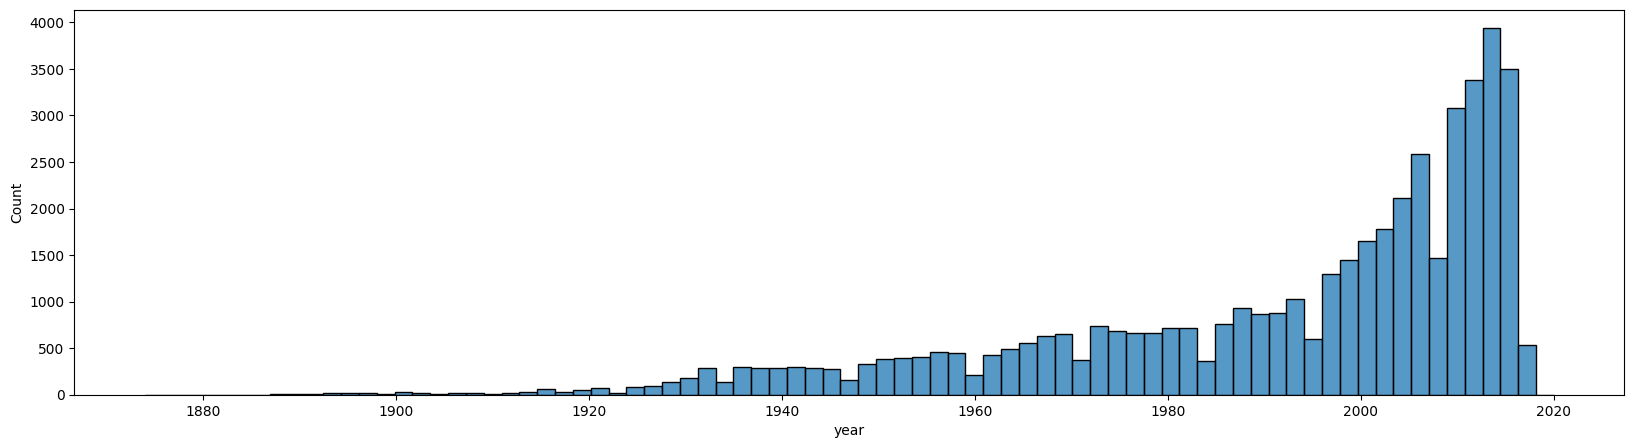

In [16]:
#checking Distribution of years
plt.figure(figsize=(20,5))
sns.histplot(movies_df['year'])
plt.show()

## movies_with_ratings

In [17]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')

links_small.rename(columns={'tmdbId': 'id'}, inplace=True)
links_small.drop(columns=['imdbId'], inplace=True)
links_small.dropna(inplace=True)
links_small.drop_duplicates(inplace=True)
links_small.drop_duplicates(subset = ['id'] ,inplace=True)

links_small['id'] = links_small['id'].astype('int')

print(f'Shape of the links_small dataframe: {links_small.shape}')

Shape of the links_small dataframe: (9112, 2)


In [18]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings = ratings.merge(links_small, on='movieId')

ratings = ratings[['userId', 'id', 'rating', 'timestamp']]

ratings.dropna(inplace=True)
ratings.drop_duplicates(inplace=True)

print(f'Shape of the links_small dataframe: {ratings.shape}')

ratings.head(3)

Shape of the links_small dataframe: (99933, 4)


,userId,id,rating,timestamp
0,1,9909,2.5,1260759144
1,7,9909,3.0,851868750
2,31,9909,4.0,1273541953


In [19]:
movies_in_ratings = movies_df[movies_df['id'].isin(ratings['id'])]

print(f'Shape of the movies_with_ratings dataframe: {movies_in_ratings.shape}')

movies_in_ratings.head(3)

Shape of the movies_with_ratings dataframe: (9025, 22)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,runtime,production_companies,director,actor,character,cast_size,crew_size,overview,tagline,keywords
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,81,[Pixar Animation Studios],John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva..."
1,tt0113497,8844,Jumanji,1995.0,"[Adventure, Fantasy, Family]",6.9,2413.0,17.015539,65000000.0,262797249.0,...,104,"[TriStar Pictures, Teitler Film, Interscope Co...",Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[Alan Parrish, Samuel Alan Parrish / Van Pelt,...",26,16,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,"[board game, disappearance, based on children'..."
2,tt0113228,15602,Grumpier Old Men,1995.0,"[Romance, Comedy]",6.5,92.0,11.712900,0.0,0.0,...,101,"[Warner Bros., Lancaster Gate]",Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[Max Goldman, John Gustafson, Ariel Gustafson]",7,4,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,"[fishing, best friend, duringcreditsstinger, o..."


## Create a new dataFrame for the mean of ratings for each product

In [20]:
movies_with_ratings = movies_in_ratings.merge(ratings, on='id')
movies_with_ratings.shape

(99810, 25)

In [21]:
average_rating_df = movies_with_ratings[["title", "rating"]].groupby('title').mean()
average_rating_df.head(3)

,rating
title,
$9.99,3.833333
'Neath the Arizona Skies,0.500000
"'night, Mother",5.000000


In [22]:
sorted_average_ratings = average_rating_df.sort_values("rating",ascending=False)
sorted_average_ratings.head(5)

,rating
title,
Female Perversions,5.0
Lake of Fire,5.0
Lamerica,5.0
The Family Stone,5.0
Riding Giants,5.0


## take the high of the frequently of the rated products

In [23]:
# Create a list of only the frequently watched movies
product_popularity = movies_with_ratings["title"].value_counts()
popular_product = product_popularity[product_popularity > 50].index # can use that code without .index to show the name and their counts

print(popular_product)

Index(['Forrest Gump', 'Pulp Fiction', 'The Shawshank Redemption',
       'The Silence of the Lambs', 'Star Wars', 'Jurassic Park', 'The Matrix',
       'Toy Story', 'Schindler's List', 'Terminator 2: Judgment Day',
       ...
       'American Psycho', 'The Birds', 'Mr. & Mrs. Smith', 'Cruel Intentions',
       'My Fair Lady', 'My Big Fat Greek Wedding',
       'The Hunchback of Notre Dame', 'Chicago', 'Shutter Island',
       'Mighty Aphrodite'],
      dtype='object', name='title', length=458)


## filter the original DataFrame to include only the popular products

In [24]:
# Use this popular_product list to filter the original DataFrame
popular_product_rankings = movies_with_ratings[movies_with_ratings["title"].isin(popular_product)]

# Inspect the product watched over 50 times
popular_product_rankings.head(3)

,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703
1,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",9,4.0,938629179
2,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",13,5.0,1331380058


### Find the top 5 popular products based on their average rating

In [25]:
# Find the average rating given to these frequently watched films
popular_product_average_rankings = popular_product_rankings[["title", "rating"]].groupby('title').mean()
print(popular_product_average_rankings.sort_values(by="rating", ascending=False).head())

                            rating
title                             
The Godfather             4.487500
The Shawshank Redemption  4.487138
The Godfather: Part II    4.385185
The Usual Suspects        4.370647
Chinatown                 4.335526


## **Knowledge based Visualization**

In [26]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')

links_small.rename(columns={'tmdbId': 'id'}, inplace=True)
links_small.drop(columns=['imdbId'], inplace=True)
links_small.dropna(inplace=True)
links_small.drop_duplicates(inplace=True)
links_small.drop_duplicates(subset = ['id'] ,inplace=True)

links_small['id'] = links_small['id'].astype('int')

print(f'Shape of the links_small dataframe: {links_small.shape}')

Shape of the links_small dataframe: (9112, 2)


In [27]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings = ratings.merge(links_small, on='movieId')

ratings = ratings[['userId', 'id', 'rating', 'timestamp']]

ratings.dropna(inplace=True)
ratings.drop_duplicates(inplace=True)

print(f'Shape of the links_small dataframe: {ratings.shape}')

Shape of the links_small dataframe: (99933, 4)


In [28]:
merged_rating_dataset = movies_df.merge(ratings, on='id')

print(f'Shape of the movies_with_ratings dataframe: {merged_rating_dataset.shape}')

merged_rating_dataset.head(1)

Shape of the movies_with_ratings dataframe: (99810, 25)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703


In [29]:
merged_dataset = merged_rating_dataset[['userId', 'id', 'title', 'genres', 'rating', 'timestamp']]
merged_dataset = merged_dataset.rename(columns={'userId':'user id', 'id':'movie id', 'title':'movie title'})
merged_dataset.head(3)

,user id,movie id,movie title,genres,rating,timestamp
0,7,862,Toy Story,"[Animation, Comedy, Family]",3.0,851866703
1,9,862,Toy Story,"[Animation, Comedy, Family]",4.0,938629179
2,13,862,Toy Story,"[Animation, Comedy, Family]",5.0,1331380058


In [30]:
# Mapping dictionary
rating_mapping = {
    0.5: 1,
    1.0: 1,
    1.5: 2,
    2.0: 2,
    2.5: 3,
    3.0: 3,
    3.5: 4,
    4.0: 4,
    4.5: 4,
    5.0: 5
}

# Apply mapping
merged_dataset['rating'] = merged_dataset['rating'].map(rating_mapping)

In [31]:
merged_dataset['rating'].value_counts()

rating
4    46915
3    24485
5    15043
2     8948
1     4419
Name: count, dtype: int64

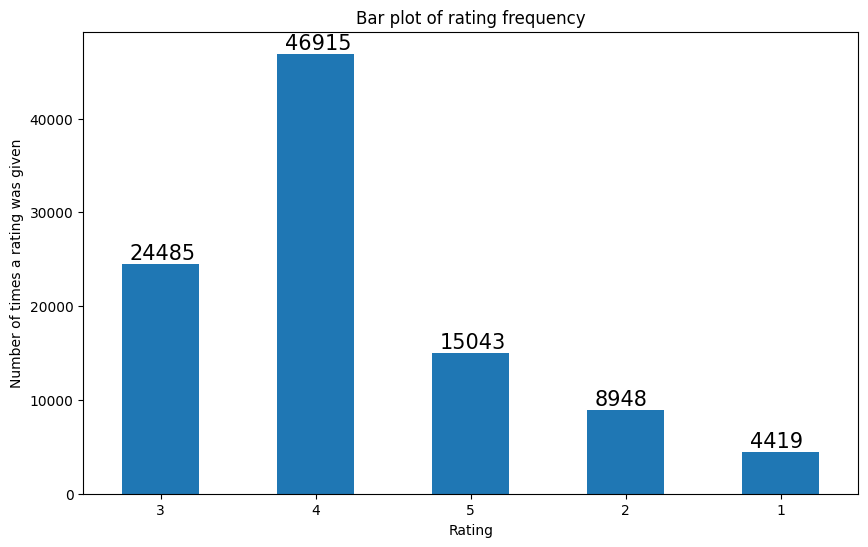

In [32]:
merged_dataset['rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')
label = list(merged_dataset['rating'].value_counts(sort=False))
r4 = [1,2,3,4,5]
for i in range(len(label)):
  plt.text(x = r4[i]-1.2 , y = label[i]+500, s = label[i], size =15)


In [33]:
avg_highly_rated_movies = merged_dataset.groupby(['movie title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()

In [34]:
avg_highly_rated_movies.head(20)

,rating
movie title,
Sammy and Rosie Get Laid,5.0
Victoria,5.0
Bill Hicks: Relentless,5.0
My Best Friend,5.0
The Night of the Shooting Stars,5.0
The Brandon Teena Story,5.0
A Passage to India,5.0
Big Eden,5.0
Yossi,5.0


In [35]:
print("Number of movies with 5 star rating on average: ",len(avg_highly_rated_movies[avg_highly_rated_movies['rating'] == 5.0]))
print("Number of movies with above 4 star and below 5 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 4.0) & (avg_highly_rated_movies['rating'] < 5.0)]))
print("Number of movies with above 3 star and below 4 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 3.0) & (avg_highly_rated_movies['rating'] < 4.0)]))
print("Number of movies with above 2 star and below 3 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 2.0) & (avg_highly_rated_movies['rating'] < 3.0)]))
print("Number of movies with above 1 star and below 2 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] >= 1.0) & (avg_highly_rated_movies['rating'] < 2.0)]))
print("Number of movies with below 1 star rating on average: ", len(avg_highly_rated_movies[(avg_highly_rated_movies['rating'] < 1.0)]))


Number of movies with 5 star rating on average:  302
Number of movies with above 4 star and below 5 star rating on average:  2461
Number of movies with above 3 star and below 4 star rating on average:  4210
Number of movies with above 2 star and below 3 star rating on average:  1407
Number of movies with above 1 star and below 2 star rating on average:  374
Number of movies with below 1 star rating on average:  0


In [36]:
print('Split of movies count based on their overall average rating')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '5 star', '4 to 5 star', '3 to 4 star', '2 to 3 star', '1 to 2 star'
values = [302, 2461, 4210, 1407, 374]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

plt.show()


Split of movies count based on their overall average rating


In [37]:
avg_highly_rated_movies.reset_index(level=0, inplace=True)

In [38]:
avg_highly_rated_movies.columns = ['movie title', 'avg rating']

avg_highly_rated_movies.head(10)

,movie title,avg rating
0,Sammy and Rosie Get Laid,5.0
1,Victoria,5.0
2,Bill Hicks: Relentless,5.0
3,My Best Friend,5.0
4,The Night of the Shooting Stars,5.0
5,The Brandon Teena Story,5.0
6,A Passage to India,5.0
7,Big Eden,5.0
8,Yossi,5.0
9,All Star Superman,5.0


In [39]:
merged_dataset.groupby(['movie title']).agg({"rating":"sum"})['rating'].sort_values(ascending=False)

movie title
The Shawshank Redemption                 1384
Forrest Gump                             1379
Pulp Fiction                             1365
The Silence of the Lambs                 1252
Star Wars                                1222
                                         ... 
Madea Goes to Jail                          1
Fraternity Vacation                         1
The End of Summer                           1
National Lampoon Presents Dorm Daze         1
The Agony and Ecstasy of Phil Spector       1
Name: rating, Length: 8754, dtype: int64

In [40]:
# merged_dataset['movie id'].value_counts(sort=False).plot(kind='bar' ,figsize=(20,6), use_index = True, rot=0)
# plt.title('Bar plot of frequency of a movie being watched')
# plt.xlabel('Movies')
# plt.ylabel('Number of times a user watched that movie')

In [41]:
popular_movies = merged_dataset.groupby(['movie title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)

popular_movies = popular_movies.to_frame()
popular_movies.reset_index(level=0, inplace=True)
popular_movies.columns = ['movie title', 'Number of Users watched']

In [42]:
print("Number of popular movies with more than 500 viewers: ",len(popular_movies[popular_movies['Number of Users watched'] >= 500]))
print("Number of popular movies with more than 400 and less than 500 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 400) & (popular_movies['Number of Users watched'] < 500)]))
print("Number of popular movies with more than 300 and less than 400 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 300) & (popular_movies['Number of Users watched'] < 400)]))
print("Number of popular movies with more than 200 and less than 300 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 200) & (popular_movies['Number of Users watched'] < 300)]))
print("Number of popular movies with more than 100 and less than 200 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 100) & (popular_movies['Number of Users watched'] < 200)]))
print("Number of popular movies with more than 50 and less than 100 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 50) & (popular_movies['Number of Users watched'] < 100)]))
print("Number of popular movies with more than 20 and less than 50 viewers: ",len(popular_movies[(popular_movies['Number of Users watched'] >= 20) & (popular_movies['Number of Users watched'] < 50)]))
print("Number of popular movies with less than 20 viewers: ", len(popular_movies[(popular_movies['Number of Users watched'] < 20)]))

Number of popular movies with more than 500 viewers:  0
Number of popular movies with more than 400 and less than 500 viewers:  0
Number of popular movies with more than 300 and less than 400 viewers:  4
Number of popular movies with more than 200 and less than 300 viewers:  25
Number of popular movies with more than 100 and less than 200 viewers:  123
Number of popular movies with more than 50 and less than 100 viewers:  314
Number of popular movies with more than 20 and less than 50 viewers:  843
Number of popular movies with less than 20 viewers:  7445


In [43]:
print('Split of movies count based on their overall viewers')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['300 to 400 viewers', '200 to 300 viewers', '100 to 200 viewers', '50 to 100 viewers', '20 to 50 viewers', 'less than 20 viewers']
values = [4, 25, 123, 314, 843, 7445]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()


Split of movies count based on their overall viewers


In [44]:
popular_movies[popular_movies['Number of Users watched'] >= 200].head(10)

,movie title,Number of Users watched
0,Forrest Gump,341
1,Pulp Fiction,324
2,The Shawshank Redemption,311
3,The Silence of the Lambs,304
4,Star Wars,291
5,Jurassic Park,274
6,The Matrix,259
7,Toy Story,247
8,Schindler's List,244
9,Terminator 2: Judgment Day,237


In [45]:
highly_rated_popular_movies = pd.merge(avg_highly_rated_movies, popular_movies, how = 'inner', on='movie title')
highly_rated_popular_movies.head(10)

,movie title,avg rating,Number of Users watched
0,Sammy and Rosie Get Laid,5.0,1
1,Victoria,5.0,1
2,Bill Hicks: Relentless,5.0,1
3,My Best Friend,5.0,1
4,The Night of the Shooting Stars,5.0,1
5,The Brandon Teena Story,5.0,1
6,A Passage to India,5.0,2
7,Big Eden,5.0,1
8,Yossi,5.0,1
9,All Star Superman,5.0,1


In [46]:
highly_rated_popular_movies[highly_rated_popular_movies['Number of Users watched'] >= 200].head(10)

,movie title,avg rating,Number of Users watched
442,The Shawshank Redemption,4.450161,311
445,The Godfather,4.445000,200
471,The Usual Suspects,4.348259,201
564,Schindler's List,4.270492,244
591,Fargo,4.250000,224
647,American Beauty,4.213636,220
648,Pulp Fiction,4.212963,324
650,The Empire Strikes Back,4.205128,234
681,Star Wars,4.199313,291
684,Raiders of the Lost Ark,4.195455,220


In [47]:
highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>=200) & (highly_rated_popular_movies['avg rating']>=4.0)].head(10)

,movie title,avg rating,Number of Users watched
442,The Shawshank Redemption,4.450161,311
445,The Godfather,4.445000,200
471,The Usual Suspects,4.348259,201
564,Schindler's List,4.270492,244
591,Fargo,4.250000,224
647,American Beauty,4.213636,220
648,Pulp Fiction,4.212963,324
650,The Empire Strikes Back,4.205128,234
681,Star Wars,4.199313,291
684,Raiders of the Lost Ark,4.195455,220


## Recommendations based on Movie Genre to a New User.

In [48]:
items_dataset = merged_dataset

In [49]:
# Extract unique genres
unique_genres = set(genre for genres in items_dataset['genres'] for genre in genres)

# Create a column for each genre with binary encoding
for genre in unique_genres:
    items_dataset[genre] = items_dataset['genres'].apply(lambda genres: 1 if genre in genres else 0)

# Drop the original genres column if no longer needed
items_dataset = items_dataset.drop(columns=['genres'])

In [50]:
movie_genre_list = items_dataset.columns[5:].tolist()
movie_genre_list

['Science Fiction',
 'Adventure',
 'Music',
 'Foreign',
 'War',
 'TV Movie',
 'Drama',
 'Thriller',
 'Documentary',
 'Horror',
 'Western',
 'History',
 'Mystery',
 'Family',
 'Fantasy',
 'Comedy',
 'Romance',
 'Animation',
 'Action',
 'Crime']

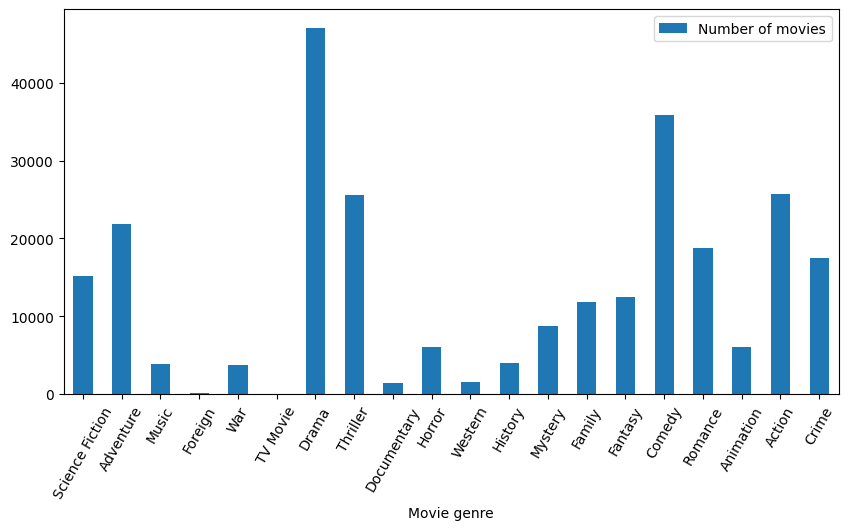

In [51]:
count = []
for i in movie_genre_list:
  # print(i)
  genre_based_movies = items_dataset[['movie id','movie title',i]]
  genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
  count.append(len(genre_based_movies))
  # merged_genre_movies = pd.merge(dataset, genre_based_movies, how='inner', on='movie id')
  # star_based_visualization(merged_genre_movies)
df_plot = pd.DataFrame({'Movie genre':movie_genre_list, 'Number of movies':count})
ax = df_plot.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

In [52]:
ratings_dataset = ratings.rename(columns={'id':'movie id'})

In [53]:
def star_based_visualization(dataframe):
    dataframe['rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
    plt.title('Bar plot of rating frequency')
    plt.xlabel('Rating')
    plt.ylabel('Number of times a rating was given')
    # label = list(dataframe['rating'].value_counts(sort=False))
    plt.show()
    print("Total number of users watched this Genre: ",len(dataframe))
    print("  ")


In [54]:
def recommendations_genre(genre):
    x = genre
    print("****************************     ******************************     ******************************")
    print("****************************     ****** GENRE: ", x," ******     ******************************")
    print("    ")
    genre_based_movies = items_dataset[['movie id','movie title',x]]
    genre_based_movies = genre_based_movies[genre_based_movies[x] == 1]
    merged_genre_movies = pd.merge(ratings_dataset, genre_based_movies, how='inner', on='movie id')
    # merged_genre_movies.head()

    star_based_visualization(merged_genre_movies)
    high_rated_movies = merged_genre_movies.groupby(['movie title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
    high_rated_movies = high_rated_movies.to_frame()
    print("These are the top movies that can be naviely suggested to the new users for the requested movie genre:", x, ". Recommendations based on top average ratings.")
    print(high_rated_movies.head(10))
    print("****************************     ******************************     ******************************")
    popular_movies_ingenre = merged_genre_movies.groupby(['movie title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
    popular_movies_ingenre = popular_movies_ingenre.to_frame()
    popular_movies_ingenre.reset_index(level=0, inplace=True)
    popular_movies_ingenre.columns = ['movie title', 'Number of Users watched']
    print("These are the most popular movies which can be recommended to a new user in",x,"genre. Recommendations based on Popularity")
    print(popular_movies_ingenre.sort_values('Number of Users watched', ascending=False).head(10))
    print("****************************     ******************************     ******************************")
    highly_rated_popular_movies = pd.merge(high_rated_movies, popular_movies_ingenre, how = 'inner', on='movie title')
    # highly_rated_popular_movies.head(10)
    viewer_limit = 300
    ratings_limit = 4.0
    count = 0
    check = 0
    while viewer_limit > 0 and ratings_limit > 0:
        s = highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>viewer_limit) & (highly_rated_popular_movies['rating']>=ratings_limit)]
        if len(s) < 11:
            if check == 0:
                viewer_limit -= 50
                check = 1
            else:
                ratings_limit -= 0.5
                check = 0
        else:
            break
    print("These movies are the best to suggest to a new user within their requested genre as they are popular and well rated by the users who already watched them.")
    print("These have rating more than ",ratings_limit," with atleast ",viewer_limit ," viewers.")

    print("**Recommendations based popularity and rating. These are top rated popular movies**")
    print(s)
    print("****************************     ******************************     ******************************")
    print("                             ")
    print("                             ")


In [55]:
# for i in movie_genre_list[1:]:
#     recommendations_genre(i)

# **Demographic Filtering**

#### Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

### where

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

In [56]:
C= df['vote_average'].mean()
print(f'Mean vote across the whole report: {C}')

# vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
# C = vote_averages.mean()

m= df['vote_count'].quantile(0.95)
print(f'Minimum votes required to be listed in the chart: {m}')

# # vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
# m = vote_counts.quantile(0.95)

Mean vote across the whole report: 5.61981583063468
Minimum votes required to be listed in the chart: 434.0


In [57]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [58]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
print(f'shape of the filtered dataframe: {qualified.shape}')

shape of the filtered dataframe: (2274, 6)


In [59]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
qualified['wr_score'] = qualified.apply(weighted_rating, axis=1)

In [60]:
#Sort movies based on score calculated above
qualified = qualified.sort_values('wr_score', ascending=False).head(250)

### Top Movies

In [61]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr_score
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",8.357825
834,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]",8.306442
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.208431
2843,Fight Club,1999,9678.0,8.3,63.869599,[Drama],8.184968
292,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]",8.172232
351,Forrest Gump,1994,8147.0,8.2,48.307194,"[Comedy, Drama, Romance]",8.069502
522,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",8.061150
23673,Whiplash,2014,4376.0,8.3,64.299990,[Drama],8.058170
5481,Spirited Away,2001,3968.0,8.3,41.048867,"[Fantasy, Adventure, Animation, Family]",8.035756
1154,The Empire Strikes Back,1980,5998.0,8.2,19.470959,"[Adventure, Action, Science Fiction]",8.025902


Text(0.5, 1.0, 'Popular Movies')

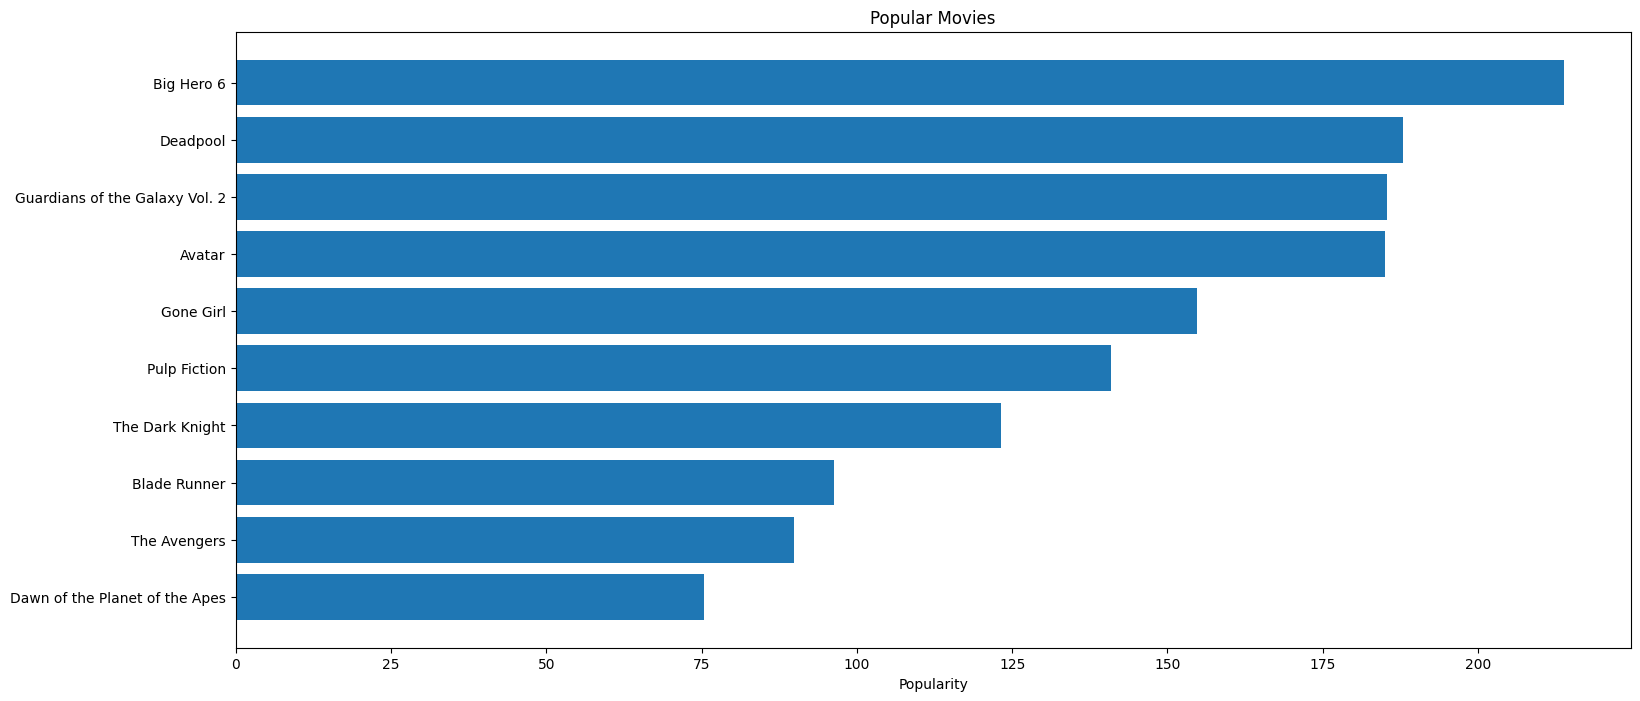

In [62]:
pop= qualified.sort_values('popularity', ascending=False)

plt.figure(figsize=(18,8))
plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


### deponed of the genres on the score

In [63]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

print(f'Shape of the genres dataframe: {gen_df.shape}')

Shape of the genres dataframe: (93378, 16)


In [64]:
def build_chart(genre, percentile=0.85):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count']
    vote_averages = df[df['vote_average'].notnull()]['vote_average']
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count']
    qualified['vote_average'] = qualified['vote_average']
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [65]:
genre_list = gen_df['genre'].value_counts().index.to_list()

print(genre_list)

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation', 'Foreign', 'Music', 'History', 'War', 'Western', 'TV Movie']


### Top Romance Movies

In [66]:
build_chart('Romance').head(10)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661.0,9.1,34.457024,8.701374
40251,Your Name.,2016,1030.0,8.5,34.461252,8.281296
351,Forrest Gump,1994,8147.0,8.2,48.307194,8.173553
1132,Cinema Paradiso,1988,834.0,8.2,14.177005,7.964468
40882,La La Land,2016,4745.0,7.9,19.681686,7.860594
22168,Her,2013,4215.0,7.9,13.829515,7.855744
7208,Eternal Sunshine of the Spotless Mind,2004,3758.0,7.9,12.906327,7.850489
876,Vertigo,1958,1162.0,8.0,18.208220,7.840649
3189,City Lights,1931,444.0,8.2,10.891524,7.792772
15530,Mr. Nobody,2009,1616.0,7.9,11.817059,7.788362


### Top Action Movies

In [67]:
build_chart('Action').head(10)

,title,year,vote_count,vote_average,popularity,wr
12481,The Dark Knight,2008,12269.0,8.3,123.167259,8.250466
1154,The Empire Strikes Back,1980,5998.0,8.2,19.470959,8.104236
15480,Inception,2010,14075.0,8.1,29.108149,8.059909
7000,The Lord of the Rings: The Return of the King,2003,8226.0,8.1,29.324358,8.032171
256,Star Wars,1977,6778.0,8.1,42.149697,8.018152
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892.0,8.0,32.070725,7.939624
5814,The Lord of the Rings: The Two Towers,2002,7641.0,8.0,29.423537,7.930026
23753,Guardians of the Galaxy,2014,10014.0,7.9,53.291601,7.848464
2458,The Matrix,1999,9079.0,7.9,33.366332,7.843287
4135,Scarface,1983,3017.0,8.0,11.299673,7.830315


# **Content Based Filtering**

In [68]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')


print(f'Shape of the links_small dataframe: {links_small.shape}')
links_small.head()

Shape of the links_small dataframe: (9112,)


0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int32

In [69]:
smd_1 = df[df['id'].isin(links_small)]

print(smd_1.shape)
smd_1.head(3)

(9082, 16)


,budget,genres,id,imdb_id,original_language,overview,popularity,production_companies,production_countries,revenue,runtime,tagline,title,vote_average,vote_count,year
0,30000000.0,"[Animation, Comedy, Family]",862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81,,Toy Story,7.7,5415.0,1995
1,65000000.0,"[Adventure, Fantasy, Family]",8844,tt0113497,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,0.0,"[Romance, Comedy]",15602,tt0113228,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995


### Movie Description Based Recommender

In [70]:
smd_1 = smd_1.copy()  # Ensures no linkage to the original DataFrame
smd_1['description'] = smd_1['title'] + ' ' + smd_1['overview'] + ' ' + smd_1['tagline']
smd_1['description'] = smd_1['description'].apply(lambda x: x.lower())

In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfve = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfve.fit_transform(smd_1['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9082, 282926)

## **Cosine similarity**

## $cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [72]:
# Compute the cosine similarity matrix
cosine_sim_1 = linear_kernel(tfidf_matrix, tfidf_matrix)
# cosine_sim_1 = cosine_similarity(tfidf_matrix, tfidf_matrix)
# cosine_sim_1 = sigmoid_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim_1.shape

(9082, 9082)

In [73]:
smd_1 = smd_1.reset_index()
titles = smd_1['title']
indices = pd.Series(smd_1.index, index=smd_1['title'])

In [74]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim, recommendations_num=10):
    
    recommendations_num = recommendations_num + 1
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:recommendations_num]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

In [75]:
get_recommendations('The Godfather', cosine_sim_1)

973      The Godfather: Part II
8382                 The Family
3508                       Made
1581    The Godfather: Part III
4195         Johnny Dangerously
5666                       Fury
2411             American Movie
29               Shanghai Triad
7755              Henry's Crime
3287          Jaws: The Revenge
Name: title, dtype: object

In [76]:
get_recommendations('The Dark Knight', cosine_sim_1)

7926                      The Dark Knight Rises
132                              Batman Forever
524                                      Batman
8222    Batman: The Dark Knight Returns, Part 2
2578               Batman: Mask of the Phantasm
1113                             Batman Returns
8160    Batman: The Dark Knight Returns, Part 1
7561                 Batman: Under the Red Hood
7896                           Batman: Year One
6141                              Batman Begins
Name: title, dtype: object

## Metadata Based Recommender

In [77]:
credits = pd.read_csv('The Movies Dataset/credits.csv')
credits.drop_duplicates(inplace=True)
credits.drop_duplicates(subset= ['id'],inplace=True)


keywords = pd.read_csv('The Movies Dataset/keywords.csv')
keywords.drop_duplicates(inplace=True)
keywords.drop_duplicates(subset= ['id'],inplace=True)

In [78]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [79]:
df = df.merge(credits, on='id')

df = df.merge(keywords, on='id')

In [80]:
smd_2 = df[df['id'].isin(links_small)]
smd_2.shape

(9082, 19)

In [81]:
smd_2[['id', 'title', 'cast', 'crew', 'keywords']].head(3)

,id,title,cast,crew,keywords
0,862,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


In [82]:
smd_2 = smd_2.copy()  # Ensures no linkage to the original DataFrame
smd_2['cast'] = smd_2['cast'].apply(literal_eval)
smd_2['crew'] = smd_2['crew'].apply(literal_eval)
smd_2['keywords'] = smd_2['keywords'].apply(literal_eval)
smd_2['cast_size'] = smd_2['cast'].apply(lambda x: len(x))
smd_2['crew_size'] = smd_2['crew'].apply(lambda x: len(x))

In [83]:
smd_2[['id', 'title', 'cast', 'cast_size', 'crew', 'crew_size', 'keywords']].head(3)

,id,title,cast,cast_size,crew,crew_size,keywords
0,862,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...",13,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",106,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",26,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",16,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",7,"[{'credit_id': '52fe466a9251416c75077a89', 'de...",4,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


In [84]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [85]:
smd_2['director'] = smd_2['crew'].apply(get_director)

In [86]:
smd_2['cast'] = smd_2['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd_2['cast'] = smd_2['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

smd_2['keywords'] = smd_2['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [87]:
smd_2[['id', 'title', 'cast', 'cast_size', 'director', 'crew_size', 'keywords']].head(3)

,id,title,cast,cast_size,director,crew_size,keywords
0,862,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",13,John Lasseter,106,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",26,Joe Johnston,16,"[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",7,Howard Deutch,4,"[fishing, best friend, duringcreditsstinger, o..."


1. **Strip Spaces and Convert to Lowercase** from all our features. This way, our engine will not confuse between **Johnny Depp** and **Johnny Galecki.** 

In [88]:
smd_2['cast'] = smd_2['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

2. **Mention Director 3 times** to give it more weight relative to the entire cast.

In [89]:
smd_2['director'] = smd_2['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd_2['director'] = smd_2['director'].apply(lambda x: [x,x, x])

#### Keywords

small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [90]:
s = smd_2.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [91]:
s = s.value_counts()
s[:5]

keyword
independent film        603
woman director          541
murder                  397
duringcreditsstinger    327
based on novel          309
Name: count, dtype: int64

In [92]:
s = s[s > 1]

In [93]:
stemmer = SnowballStemmer('english')

In [94]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [95]:
smd_2['keywords'] = smd_2['keywords'].apply(filter_keywords)
smd_2['keywords'] = smd_2['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd_2['keywords'] = smd_2['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [96]:
smd_2['soup'] = smd_2['keywords'] + smd_2['cast'] + smd_2['director'] + smd_2['genres']
smd_2['soup'] = smd_2['soup'].apply(lambda x: ' '.join(x))

### CountVectorizer

In [97]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
count_matrix = count.fit_transform(smd_2['soup'])

In [98]:
cosine_sim_2 = cosine_similarity(count_matrix, count_matrix)

cosine_sim_2.shape

(9082, 9082)

In [99]:
smd_2 = smd_2.reset_index()
titles = smd_2['title']
indices = pd.Series(smd_2.index, index=smd_2['title'])

In [100]:
get_recommendations('The Dark Knight', cosine_sim_2)

7926         The Dark Knight Rises
6141                 Batman Begins
6539                  The Prestige
2064                     Following
7550                     Inception
4103                      Insomnia
3360                       Memento
8501                  Interstellar
7561    Batman: Under the Red Hood
1113                Batman Returns
Name: title, dtype: object

In [101]:
get_recommendations('Mean Girls', cosine_sim_2)

3298               Head Over Heels
4707                 Freaky Friday
1308              The House of Yes
6200              Just Like Heaven
7800         Mr. Popper's Penguins
7241    Ghosts of Girlfriends Past
6875     The Spiderwick Chronicles
8764                      The DUFF
6614         It's a Boy Girl Thing
7279       I Love You, Beth Cooper
Name: title, dtype: object

### Popularity and Ratings

In [102]:
def improved_recommendations(title, cosine_sim, recommendations_num=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd_2.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count']
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average']
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified = qualified.copy()
    qualified['vote_count'] = qualified['vote_count']
    qualified['vote_average'] = qualified['vote_average']
    qualified['wr_score'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr_score', ascending=False).head(recommendations_num)
    return qualified

In [103]:
improved_recommendations('The Dark Knight', cosine_sim_2)

,title,vote_count,vote_average,year,wr_score
7550,Inception,14075.0,8.1,2010,8.025812
8501,Interstellar,11187.0,8.1,2014,8.007375
3360,Memento,4168.0,8.1,2000,7.866102
6539,The Prestige,4510.0,8.0,2006,7.791060
7926,The Dark Knight Rises,9263.0,7.6,2012,7.511375
6141,Batman Begins,7511.0,7.5,2005,7.397294
1113,Batman Returns,1706.0,6.6,1992,6.401215
8905,Batman v Superman: Dawn of Justice,7189.0,5.7,2016,5.695435
132,Batman Forever,1529.0,5.2,1995,5.292817
1239,Batman & Robin,1447.0,4.2,1997,4.527592


In [104]:
improved_recommendations('Mean Girls', cosine_sim_2)

,title,vote_count,vote_average,year,wr_score
1526,The Breakfast Club,2189.0,7.8,1985,7.439268
390,Dazed and Confused,588.0,7.4,1993,6.644031
8764,The DUFF,1372.0,6.8,2015,6.516390
3677,The Princess Diaries,1063.0,6.5,2001,6.244823
6200,Just Like Heaven,595.0,6.5,2005,6.128766
6875,The Spiderwick Chronicles,593.0,6.3,2008,6.012561
4707,Freaky Friday,919.0,6.0,2003,5.878049
7800,Mr. Popper's Penguins,775.0,5.7,2011,5.671216
7241,Ghosts of Girlfriends Past,716.0,5.6,2009,5.607478
7396,American Pie Presents: The Book of Love,454.0,5.1,2009,5.354054


## Using only Numerical column for **Content Based Filtering**

In [105]:
smd_2.head(3)

,index,budget,genres,id,imdb_id,original_language,overview,popularity,production_companies,production_countries,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,0,30000000.0,"[Animation, Comedy, Family]",862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,65000000.0,"[Adventure, Fantasy, Family]",8844,tt0113497,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,2,0.0,"[Romance, Comedy]",15602,tt0113228,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...


In [106]:
ndf = smd_2.select_dtypes(include=["float64","int64","float32","int32"])

ndf.drop(columns=['index','id'], inplace=True)

print(f'ndf shape is: {ndf.shape}')

ndf.head()

ndf shape is: (9082, 9)


,budget,popularity,revenue,runtime,vote_average,vote_count,year,cast_size,crew_size
0,30000000.0,21.946943,373554033.0,81,7.7,5415.0,1995,13,106
1,65000000.0,17.015539,262797249.0,104,6.9,2413.0,1995,26,16
2,0.0,11.712900,0.0,101,6.5,92.0,1995,7,4
3,16000000.0,3.859495,81452156.0,127,6.1,34.0,1995,10,10
4,0.0,8.387519,76578911.0,106,5.7,173.0,1995,12,7


In [107]:
# Create MinMaxScaler Object
scaler = MinMaxScaler(feature_range=(0, 1))

# Create dataframe after transformation
ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))

# assign column names
ndfmx.columns=ndf.columns

# Show initial 5 records
ndfmx.head()


,budget,popularity,revenue,runtime,vote_average,vote_count,year,cast_size,crew_size
0,0.078947,0.040087,0.133988,0.071053,0.77,0.384725,0.815789,0.041534,0.243678
1,0.171053,0.031079,0.094261,0.091228,0.69,0.171439,0.815789,0.083067,0.036782
2,0.000000,0.021394,0.000000,0.088596,0.65,0.006536,0.815789,0.022364,0.009195
3,0.042105,0.007049,0.029216,0.111404,0.61,0.002416,0.815789,0.031949,0.022989
4,0.000000,0.015320,0.027468,0.092982,0.57,0.012291,0.815789,0.038339,0.016092


In [108]:
# Compute the cosine similarity
cosine_sim_3 = cosine_similarity(ndfmx, ndfmx)

cosine_sim_3.shape

(9082, 9082)

In [109]:
# Reverse mapping of indices and movie titles
indices = pd.Series(smd_2.index, index=smd_2['title']).drop_duplicates()

print(f'Indices shape is: {indices.shape}')
indices.head()

Indices shape is: (9082,)


title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

In [110]:
get_recommendations('The Dark Knight', cosine_sim_3)

8600       Guardians of the Galaxy
7864                  The Avengers
6925                      Iron Man
8280                    Iron Man 3
8198              Django Unchained
8501                  Interstellar
8885                 Suicide Squad
8745            Mad Max: Fury Road
6141                 Batman Begins
8753    Captain America: Civil War
Name: title, dtype: object

# **Marge two cosine similarity matrices**

In [111]:
alpha = 0.3  # Hyperparameter to balance the two matrices

combine_cosine_sim = alpha * cosine_sim_1 + (1 - alpha) * cosine_sim_2

combine_cosine_sim.shape

(9082, 9082)

In [112]:
get_recommendations('The Dark Knight Rises', combine_cosine_sim)

6897    The Dark Knight
6141      Batman Begins
2064          Following
6539       The Prestige
7550          Inception
4103           Insomnia
3360            Memento
8501       Interstellar
1113     Batman Returns
132      Batman Forever
Name: title, dtype: object

In [113]:
improved_recommendations('The Dark Knight Rises', combine_cosine_sim)

,title,vote_count,vote_average,year,wr_score
6897,The Dark Knight,12269.0,8.3,2008,8.208431
7550,Inception,14075.0,8.1,2010,8.025812
8501,Interstellar,11187.0,8.1,2014,8.007375
3360,Memento,4168.0,8.1,2000,7.866102
6539,The Prestige,4510.0,8.0,2006,7.791060
6141,Batman Begins,7511.0,7.5,2005,7.397294
524,Batman,2145.0,7.0,1989,6.767739
1113,Batman Returns,1706.0,6.6,1992,6.401215
132,Batman Forever,1529.0,5.2,1995,5.292817
1239,Batman & Robin,1447.0,4.2,1997,4.527592


In [114]:
get_recommendations('The Godfather', combine_cosine_sim)

973            The Godfather: Part II
3581    Tucker: The Man and His Dream
1325                    The Rainmaker
3670                  The Cotton Club
3279                 Gardens of Stone
4462               One from the Heart
1581          The Godfather: Part III
2977                 The Conversation
5797                      Rumble Fish
1971            Peggy Sue Got Married
Name: title, dtype: object

In [115]:
improved_recommendations('The Godfather', combine_cosine_sim)

,title,vote_count,vote_average,year,wr_score
973,The Godfather: Part II,3418.0,8.3,1974,7.998027
965,GoodFellas,3211.0,8.2,1990,7.892785
960,Apocalypse Now,2112.0,8.0,1979,7.594266
1581,The Godfather: Part III,1589.0,7.1,1990,6.782452
1079,Dracula,1087.0,7.1,1992,6.677646
2977,The Conversation,377.0,7.5,1974,6.493835
2787,Midnight Express,309.0,7.6,1978,6.443338
8382,The Family,1052.0,6.1,2013,5.959758
7366,The Bad Lieutenant: Port of Call - New Orleans,331.0,6.0,2009,5.784314
635,Jack,340.0,5.9,1996,5.742894


In [116]:
get_recommendations('Mean Girls', combine_cosine_sim)

3298               Head Over Heels
4707                 Freaky Friday
6200              Just Like Heaven
1308              The House of Yes
7800         Mr. Popper's Penguins
7241    Ghosts of Girlfriends Past
6875     The Spiderwick Chronicles
8764                      The DUFF
6614         It's a Boy Girl Thing
7279       I Love You, Beth Cooper
Name: title, dtype: object

In [117]:
improved_recommendations('Mean Girls', combine_cosine_sim)

,title,vote_count,vote_average,year,wr_score
1526,The Breakfast Club,2189.0,7.8,1985,7.439268
8764,The DUFF,1372.0,6.8,2015,6.516390
3677,The Princess Diaries,1063.0,6.5,2001,6.244823
5395,Napoleon Dynamite,567.0,6.7,2004,6.231668
6200,Just Like Heaven,595.0,6.5,2005,6.128766
6875,The Spiderwick Chronicles,593.0,6.3,2008,6.012561
4707,Freaky Friday,919.0,6.0,2003,5.878049
7800,Mr. Popper's Penguins,775.0,5.7,2011,5.671216
7241,Ghosts of Girlfriends Past,716.0,5.6,2009,5.607478
7396,American Pie Presents: The Book of Love,454.0,5.1,2009,5.354054


# **Rating Dataset**

In [118]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
links_rec = pd.read_csv('The Movies Dataset/links_small.csv')

print(ratings.shape)

ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [119]:
links_rec

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


# **Collaborative Filtering**

In [120]:
# Define the reader
reader = Reader()

# Create the dataset
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Perform K-fold cross-validation
kf = KFold(n_splits=5)
svd = SVD()

# for trainset, testset in kf.split(data):
#     svd.fit(trainset)
#     predictions = svd.test(testset)
#     # Process predictions if needed

# Alternatively, use cross_validate for a higher-level API
results = cross_validate(svd, data,  measures=['RMSE', 'MAE'], cv=5, verbose=True)

results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8974  0.8946  0.8927  0.9008  0.9028  0.8976  0.0038  
MAE (testset)     0.6891  0.6885  0.6879  0.6944  0.6949  0.6910  0.0030  
Fit time          0.98    0.50    0.49    0.48    0.47    0.58    0.20    
Test time         0.06    0.05    0.05    0.05    0.05    0.05    0.01    


{'test_rmse': array([0.89743986, 0.89455317, 0.89265507, 0.90076263, 0.90279278]),
 'test_mae': array([0.68906044, 0.68850006, 0.68794971, 0.69437293, 0.6949475 ]),
 'fit_time': (0.975999116897583,
  0.502007246017456,
  0.49000048637390137,
  0.47600269317626953,
  0.4719986915588379),
 'test_time': (0.06199812889099121,
  0.04899168014526367,
  0.04899930953979492,
  0.05499720573425293,
  0.04800128936767578)}

In [121]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [122]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [123]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.531635720763929, details={'was_impossible': False})

In [124]:
def collaborative_filtering_svd(
    user_id, n_recommendations=10, svd_model=svd, ratings_df=ratings, movies_df=df, links_df=links_rec
):
    # Merge datasets to link movieId with TMDb metadata
    merged_df = ratings_df.merge(links_df, on="movieId")
    merged_df = merged_df.merge(movies_df[["id", "title", "vote_average", "vote_count", "year"]], 
                                left_on="tmdbId", right_on="id", how="left")
    
    # Get the list of movies the user has already watched
    watched_movies = ratings_df[ratings_df["userId"] == user_id]["movieId"].tolist()
    
    # Get all unique movie IDs
    movie_ids = ratings_df["movieId"].unique()
    
    # Predict ratings for all movies the user hasn't watched
    predictions = [
        svd_model.predict(user_id, movie_id) for movie_id in movie_ids if movie_id not in watched_movies
    ]
    
    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N recommendations
    top_movie_ids = [pred.iid for pred in predictions[:n_recommendations]]
    
    # Retrieve movie details
    recommended_movies = merged_df[merged_df["movieId"].isin(top_movie_ids)].drop_duplicates(subset="movieId")
    
    # Prepare the result DataFrame
    result = recommended_movies[["title", "vote_count", "vote_average", "year"]].copy()
    result["predicted_rating"] = [pred.est for pred in predictions[:n_recommendations]]
    result = result.sort_values(by="predicted_rating", ascending=False).head(n_recommendations)
    
    return result


In [125]:
# Get recommendations
user_recommendations = collaborative_filtering_svd(1)
user_recommendations

,title,vote_count,vote_average,year,predicted_rating
13298,Star Wars,6778.0,8.1,1977.0,3.692675
16173,Monty Python and the Holy Grail,1742.0,7.8,1975.0,3.682243
28140,The Pianist,1927.0,8.1,2002.0,3.629920
41121,NaN,NaN,NaN,NaN,3.585312
45024,Rear Window,1531.0,8.2,1954.0,3.566524
45474,Sunset Boulevard,533.0,8.2,1950.0,3.564920
46639,The Third Man,431.0,7.9,1949.0,3.564358
46677,Ran,349.0,7.9,1985.0,3.541744
49853,On the Waterfront,368.0,8.0,1954.0,3.540252
82470,Gladiator 1992,28.0,5.7,1992.0,3.536396


In [126]:
# Get recommendations
user_recommendations = collaborative_filtering_svd(500)
user_recommendations

,title,vote_count,vote_average,year,predicted_rating
165,Cinema Paradiso,834.0,8.2,1988.0,4.328146
9775,Trainspotting,2737.0,7.8,1996.0,4.113784
45024,Rear Window,1531.0,8.2,1954.0,4.103427
46620,Wings of Desire,256.0,7.5,1987.0,4.000668
51500,"Lock, Stock and Two Smoking Barrels",1671.0,7.5,1998.0,3.973525
64489,There Will Be Blood,1581.0,7.9,2007.0,3.951464
71899,Winnie the Pooh and the Blustery Day,20.0,7.8,1968.0,3.944459
74084,Sophie's Choice,149.0,7.4,1982.0,3.938655
74410,Chariots of Fire,213.0,6.9,1981.0,3.920231
75785,Howl's Moving Castle,2049.0,8.2,2004.0,3.887503


## Another way for collaborative filtering

In [127]:
print(f'movies_with_ratings shape: {movies_with_ratings.shape}')

movies_with_ratings.head(3)

movies_with_ratings shape: (99810, 25)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703
1,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",9,4.0,938629179
2,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",13,5.0,1331380058


In [128]:
# Use pivot_table with an aggregation function to handle duplicates
user_ratings_df = movies_with_ratings.pivot_table(index='userId', columns='title', values='rating', aggfunc='mean')

print(f'user_ratings_table shape: {user_ratings_df.shape}')

# Inspect the transformed table
user_ratings_df.head()

user_ratings_table shape: (671, 8754)


title,$9.99,'Neath the Arizona Skies,"'night, Mother",(500) Days of Summer,...And God Created Woman,...And Justice for All,1-900,10,10 Attitudes,10 Cloverfield Lane,...,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,Æon Flux,İtirazım Var,Želary,’Round Midnight
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Count the occupied cells
sparsity_count = user_ratings_df.isnull().values.sum()

# Count all cells
full_count = user_ratings_df.size

# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity)

0.9830658635251945


In [130]:
# Count the occupied cells per column
occupied_count = user_ratings_df.notnull().sum()
print(occupied_count)

title
$9.99                        3
'Neath the Arizona Skies     1
'night, Mother               3
(500) Days of Summer        45
...And God Created Woman     1
                            ..
À Nous la Liberté            1
Æon Flux                    13
İtirazım Var                 1
Želary                       1
’Round Midnight              2
Length: 8754, dtype: int64


In [131]:
# Sort the resulting series from low to high
sorted_occupied_count = occupied_count.sort_values()
print(sorted_occupied_count)

title
My Tutor                      1
Fat Albert                    1
Fata Morgana                  1
Sex and the City 2            1
Sex Ed                        1
                           ... 
Star Wars                   291
The Silence of the Lambs    304
The Shawshank Redemption    311
Pulp Fiction                324
Forrest Gump                341
Length: 8754, dtype: int64


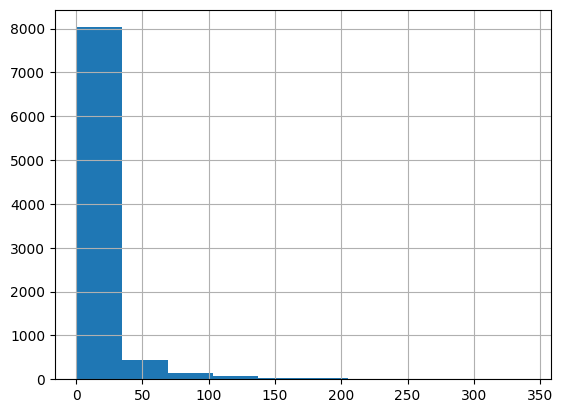

In [132]:
# Plot a histogram of the values in sorted_occupied_count
sorted_occupied_count.hist()
plt.show()

In [133]:
# Get the average rating for each user 
avg_ratings = user_ratings_df.mean(axis=1)

# Center each user's ratings around 0
user_ratings_centered = user_ratings_df.sub(avg_ratings, axis=1)

# Fill in all missing values with 0s
user_ratings_centered.fillna(0, inplace=True)

# Print the mean of each column
print(user_ratings_centered.mean(axis=1))

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
667    0.0
668    0.0
669    0.0
670    0.0
671    0.0
Length: 671, dtype: float64


In [134]:
# Check if the matrix is non-zero after centering
if not user_ratings_centered.values.any():
    print("Matrix is entirely zeros after centering. Consider adjusting the centering method.")
    
    user_ratings_standardized = user_ratings_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
    user_ratings_standardized.fillna(0, inplace=True)

    # Convert to NumPy array
    user_ratings_standardized_matrix = user_ratings_standardized.values

    # Perform SVD on the standardized matrix
    U, sigma, Vt = svds(user_ratings_standardized_matrix, k=6)
    sigma = np.diag(sigma)
    print(sigma)
    
else:
    # Perform SVD with a higher k value
    U, sigma, Vt = svds(user_ratings_centered.values, k=6)
    sigma = np.diag(sigma)
    print(sigma)


Matrix is entirely zeros after centering. Consider adjusting the centering method.
[[39.25683423  0.          0.          0.          0.          0.        ]
 [ 0.         40.62920444  0.          0.          0.          0.        ]
 [ 0.          0.         41.38688185  0.          0.          0.        ]
 [ 0.          0.          0.         43.4832371   0.          0.        ]
 [ 0.          0.          0.          0.         49.36824467  0.        ]
 [ 0.          0.          0.          0.          0.         73.66737147]]


In [135]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

# Add the row means back contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)

In [136]:
# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=user_ratings_df.index,
                                    columns=user_ratings_df.columns
                                   )
# Print both the recalculated matrix and the original 
calc_pred_ratings_df

title,$9.99,'Neath the Arizona Skies,"'night, Mother",(500) Days of Summer,...And God Created Woman,...And Justice for All,1-900,10,10 Attitudes,10 Cloverfield Lane,...,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,Æon Flux,İtirazım Var,Želary,’Round Midnight
userId,,,,,,,,,,,,,,,,,,,,,
1,2.549705,2.549999,2.550004,2.549753,2.550014,2.546917,2.550176,2.546712,2.550018,2.550035,...,2.547268,2.549999,2.549343,2.550259,2.548660,2.550056,2.551469,2.550016,2.549947,2.551013
2,3.479251,3.479971,3.479265,3.489538,3.480130,3.481975,3.481396,3.479263,3.479952,3.481679,...,3.464784,3.480131,3.472079,3.479869,3.467502,3.479900,3.484841,3.479934,3.480607,3.479320
3,3.566049,3.568587,3.565773,3.586859,3.568693,3.567963,3.570445,3.563692,3.568687,3.570566,...,3.555384,3.569209,3.535110,3.567378,3.560625,3.569098,3.573323,3.568418,3.569134,3.567877
4,4.344740,4.347802,4.371644,4.371046,4.348632,4.384209,4.354180,4.358987,4.347702,4.345705,...,4.310102,4.348653,4.261642,4.346051,4.290059,4.347796,4.319181,4.347922,4.349488,4.345931
5,3.913999,3.910010,3.924983,3.905412,3.909843,3.907943,3.907064,3.903932,3.909928,3.918410,...,3.919784,3.909110,3.973838,3.910502,3.899026,3.908721,3.916833,3.910132,3.910690,3.913582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3.644849,3.647016,3.650973,3.654728,3.647169,3.660816,3.649226,3.647727,3.647067,3.646716,...,3.638770,3.647407,3.628626,3.648180,3.631857,3.647303,3.658224,3.647034,3.647467,3.645004
668,3.788227,3.789440,3.789119,3.795585,3.789588,3.786319,3.790778,3.785831,3.789462,3.789042,...,3.777127,3.789685,3.767466,3.788873,3.782204,3.789664,3.785042,3.789419,3.789591,3.790547
669,3.350523,3.351284,3.354207,3.363299,3.351459,3.351825,3.352410,3.352592,3.351282,3.351512,...,3.342127,3.351674,3.312845,3.348529,3.343886,3.351448,3.331419,3.351184,3.351661,3.351695


In [137]:
# Sort the ratings of User 5 from high to low
user_5_ratings = calc_pred_ratings_df.loc[4,:].sort_values(ascending=False)

print(user_5_ratings)

title
The Shawshank Redemption      4.901910
Star Wars                     4.832218
Pulp Fiction                  4.825053
Schindler's List              4.802232
The Empire Strikes Back       4.769980
                                ...   
Batman & Robin                4.099112
Congo                         4.098395
Ace Ventura: Pet Detective    4.089053
Batman Forever                4.088364
Waterworld                    4.037323
Name: 4, Length: 8754, dtype: float64


In [138]:
act_ratings_df = user_ratings_df

avg_pred_ratings_df = pd.DataFrame(np.tile(avg_ratings.values, (user_ratings_df.shape[1], 1)).T, 
                                    index=user_ratings_df.index, 
                                    columns=user_ratings_df.columns)

# Extract the ground truth to compare your predictions against
actual_values = act_ratings_df.iloc[:20, :100].values
avg_values = avg_pred_ratings_df.iloc[:20, :100].values
predicted_values = calc_pred_ratings_df.iloc[:20, :100].values

# Create a mask of actual_values to only look at the non-missing values in the ground truth
mask = ~np.isnan(actual_values)

# Print the performance of both predictions and compare
print(mean_squared_error(actual_values[mask], avg_values[mask], squared=False))
print(mean_squared_error(actual_values[mask], predicted_values[mask], squared=False))

1.2253892223648926
0.7461972136687867


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



## Another way for collaborative filtering

In [183]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')

links_small.rename(columns={'tmdbId': 'id'}, inplace=True)
links_small.drop(columns=['imdbId'], inplace=True)
links_small.dropna(inplace=True)
links_small.drop_duplicates(inplace=True)
links_small.drop_duplicates(subset = ['id'] ,inplace=True)

links_small['id'] = links_small['id'].astype('int')

print(f'Shape of the links_small dataframe: {links_small.shape}')

Shape of the links_small dataframe: (9112, 2)


In [184]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings = ratings.merge(links_small, on='movieId')

ratings = ratings[['userId', 'id', 'rating', 'timestamp']]

ratings.dropna(inplace=True)
ratings.drop_duplicates(inplace=True)

print(f'Shape of the links_small dataframe: {ratings.shape}')

Shape of the links_small dataframe: (99933, 4)


In [185]:
merged_rating_dataset = movies_df.merge(ratings, on='id')

print(f'Shape of the movies_with_ratings dataframe: {merged_rating_dataset.shape}')

merged_rating_dataset.head(1)

Shape of the movies_with_ratings dataframe: (99810, 25)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703


In [187]:
refined_dataset = merged_rating_dataset[['userId', 'title', 'rating']]
refined_dataset = refined_dataset.rename(columns={'userId':'user id', 'title':'movie title'})

refined_dataset = refined_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})


print(f'Shape of the movies_with_ratings dataframe: {refined_dataset.shape}')

refined_dataset.head(3)

Shape of the movies_with_ratings dataframe: (99470, 3)


,user id,movie title,rating
0,1,Antz,2.0
1,1,Beavis and Butt-Head Do America,1.0
2,1,Ben-Hur,2.0


In [188]:
#list of all users
unique_users = refined_dataset['user id'].unique() 
#creating a list of all movie names in it
unique_movies = refined_dataset['movie title'].unique()
len(unique_movies),len(unique_users)

(8754, 671)

In [189]:
users_list = refined_dataset['user id'].tolist()
movie_list = refined_dataset['movie title'].tolist()
len(users_list),len(movie_list)

(99470, 99470)

In [191]:
ratings_list = refined_dataset['rating'].tolist()
print(len(ratings_list))

99470


In [192]:
movies_dict = {unique_movies[i] : i for i in range(len(unique_movies))}
print(len(movies_dict))

8754


In [193]:
## creating a utility matrix for the available data

## Creating an empty array with (number of rows = number of movies) and (number of columns = number of users) rows as movies, columns as users

utility_matrix = np.asarray([[np.nan for j in range(len(unique_users))] for i in range(len(unique_movies))])
print("Shape of Utility matrix: ",utility_matrix.shape)

for i in range(len(ratings_list)):

    ## ith entry in users list and subtract 1 to get the index, we do the same for movies but we already defined a dictionary to get the index.
    utility_matrix[movies_dict[movie_list[i]]][users_list[i]-1] = ratings_list[i]

utility_matrix

Shape of Utility matrix:  (8754, 671)


array([[ 2., nan, nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan, nan, nan],
       [ 2., nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Normalizing the utility matrix across movies column

In [194]:
mask = np.isnan(utility_matrix)
masked_arr = np.ma.masked_array(utility_matrix, mask)
temp_mask = masked_arr.T
rating_means = np.mean(temp_mask, axis=0)

filled_matrix = temp_mask.filled(rating_means)
filled_matrix = filled_matrix.T
filled_matrix = filled_matrix - rating_means.data[:,np.newaxis]

In [196]:
filled_matrix = filled_matrix.T / np.sqrt(len(movies_dict)-1)
print(filled_matrix.shape)
filled_matrix

(8754, 671)


array([[-0.0001455 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00023222,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00021877,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Computing SVD (Singular Value Decomposition) of Utility matrix

In [197]:
## Computing the SVD of the input matrix

U, S, V = np.linalg.svd(filled_matrix)

In [198]:
case_insensitive_movies_list = [i.lower() for i in unique_movies]

### Defining a function to calculate the cosine similarity on the given dataframe and extracting requesting number of closely matched movie indices with the help of numpy einsum which valuates the Einstein summation convention on the operands.

In [199]:
#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id 
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

### Defining a function to get similar movies for the given movie name

In [200]:
#k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
def get_similar_movies(movie_name,top_n,k = 50):
    # k = 50
    # movie_id = 1
    # top_n = 10
    
    sliced = V.T[:, :k] # representative data
    movie_id = movies_dict[movie_name]
    indexes = top_cosine_similarity(sliced, movie_id, top_n)
    print(" ")
    print("Top",top_n,"movies which are very much similar to the Movie-",movie_name, "are: ")
    print(" ")
    for i in indexes[1:]:
        print(unique_movies[i])

In [201]:
def get_possible_movies(movie):
    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
        out = []
        temp += i
        for j in possible_movies:
            if temp in j:
                out.append(j)
        if len(out) == 0:
            return possible_movies
        out.sort()
        possible_movies = out.copy()
    return possible_movies

In [202]:
class invalid(Exception):
    pass

def recommender():
    
    try:
        movie_name = input("Enter the Movie name: ")
        movie_name_lower = movie_name.lower()
        if movie_name_lower not in case_insensitive_movies_list :
            raise invalid
        else :
            # movies_list[case_insensitive_country_names.index(movie_name_lower)]
            num_recom = int(input("Enter Number of movie recommendations needed: "))
            get_similar_movies(unique_movies[case_insensitive_movies_list.index(movie_name_lower)],num_recom)
    except invalid:
        possible_movies = get_possible_movies(movie_name_lower)
        if len(possible_movies) == len(unique_movies) :
            print("Movie name entered is does not exist in the list ")
        else :
            indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
            print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[unique_movies[i] for i in indices])
            print("")
            recommender()

In [203]:
recommender()

 
Top 15 movies which are very much similar to the Movie- Toy Story are: 
 
Double Jeopardy
The Sound of Music
Highlander
Wag the Dog
The Rock
Othello
Interview with the Vampire
The Godfather: Part III
You've Got Mail
The Gods Must Be Crazy
Pretty Woman
Cool Hand Luke
Mystery Men
Lethal Weapon


# **Item Based Collaborative Filtering KNN**

In [139]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')

links_small.rename(columns={'tmdbId': 'id'}, inplace=True)
links_small.drop(columns=['imdbId'], inplace=True)
links_small.dropna(inplace=True)
links_small.drop_duplicates(inplace=True)
links_small.drop_duplicates(subset = ['id'] ,inplace=True)

links_small['id'] = links_small['id'].astype('int')

print(f'Shape of the links_small dataframe: {links_small.shape}')

Shape of the links_small dataframe: (9112, 2)


In [140]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings = ratings.merge(links_small, on='movieId')

ratings = ratings[['userId', 'id', 'rating', 'timestamp']]

ratings.dropna(inplace=True)
ratings.drop_duplicates(inplace=True)

print(f'Shape of the links_small dataframe: {ratings.shape}')

Shape of the links_small dataframe: (99933, 4)


In [141]:
merged_rating_dataset = movies_df.merge(ratings, on='id')

print(f'Shape of the movies_with_ratings dataframe: {merged_rating_dataset.shape}')

merged_rating_dataset.head(1)

Shape of the movies_with_ratings dataframe: (99810, 25)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703


### **Plot rating frequency of all movies**

In [142]:
refined_dataset = merged_rating_dataset[['userId', 'title', 'rating']]
refined_dataset = refined_dataset.rename(columns={'userId':'user id', 'title':'movie title'})

print(f'Shape of the movies_with_ratings dataframe: {refined_dataset.shape}')

refined_dataset.head(3)

Shape of the movies_with_ratings dataframe: (99810, 3)


,user id,movie title,rating
0,7,Toy Story,3.0
1,9,Toy Story,4.0
2,13,Toy Story,5.0


In [143]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('movie title').size(), columns=['count'])
movies_count_df.head()

,count
movie title,
$9.99,3
'Neath the Arizona Skies,1
"'night, Mother",3
(500) Days of Summer,45
...And God Created Woman,1


Text(0, 0.5, 'number of ratings')

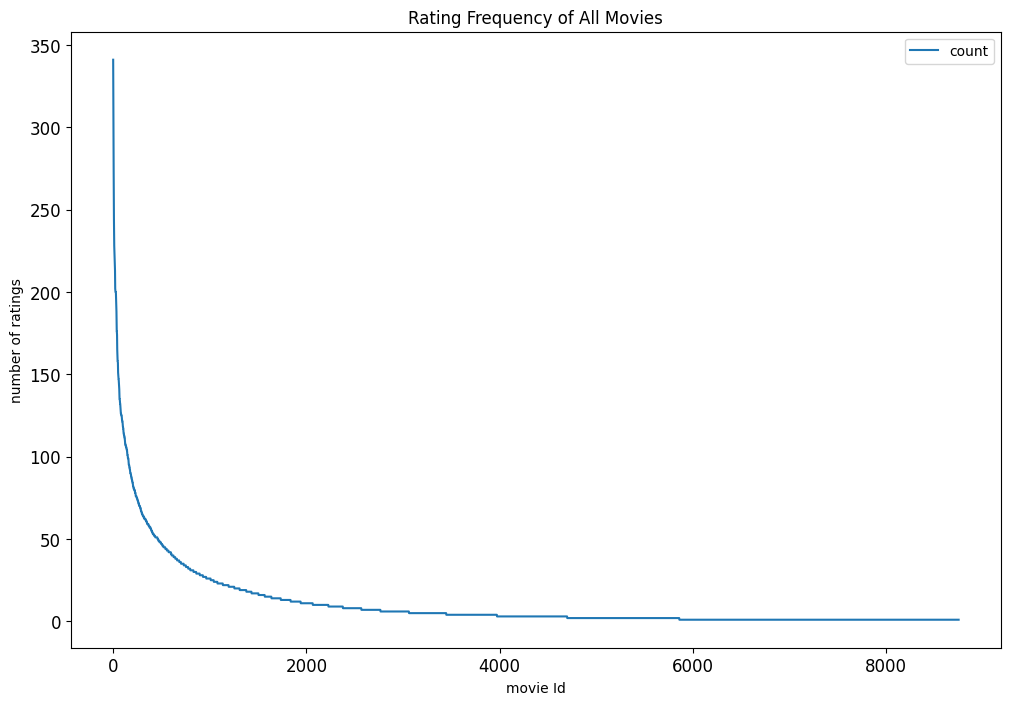

In [144]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

**As the size of MovieLens dataset picked for this project is small. There is no need of removing rarely rated movies or users who has given rating for fewer movies.**

**Also because the dataset considered is small, we do not see the long-tail property which will be the scenario with the distribution of ratings.**

*If the dataset is larger, then* (this can be referred when we do similar kind of tasks with a larger dataset, just for future reference)

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

## **Training KNN model to build item-based collaborative Recommender System**

#### Movie Recommendation using KNN with Input as **User id**, Number of similar users should the model pick and Number of movies you want to get recommended:

In [145]:
# Handle duplicates by averaging the ratings
refined_dataset = refined_dataset.groupby(['user id', 'movie title'], as_index=False)['rating'].mean()

# Create the pivot table
user_to_movie_df = refined_dataset.pivot(
    index='user id',
    columns='movie title',
    values='rating'
).fillna(0)

user_to_movie_df.head()


movie title,$9.99,'Neath the Arizona Skies,"'night, Mother",(500) Days of Summer,...And God Created Woman,...And Justice for All,1-900,10,10 Attitudes,10 Cloverfield Lane,...,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,Æon Flux,İtirazım Var,Želary,’Round Midnight
user id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<671x8754 sparse matrix of type '<class 'numpy.float64'>'
	with 99470 stored elements in Compressed Sparse Row format>

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [147]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [148]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
    ## input to this function is the user and number of top similar users you want.

    knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
    # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


**Specify User id and Number of similar users we want to consider here**

In [149]:
from pprint import pprint
user_id = 600
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of movies seen by the User:
['A Beautiful Mind',
 'About Time',
 'Aladdin',
 'Avatar',
 'Brave',
 'Finding Nemo',
 'Gone Girl',
 'Gravity',
 "Hachi: A Dog's Tale",
 'Harry Potter and the Prisoner of Azkaban']
Top 5 users who are very much similar to the User- 600 are: 
 
1 . User: 625 separated by distance of 0.7070687710325709
2 . User: 149 separated by distance of 0.7704029625171946
3 . User: 542 separated by distance of 0.7828557667625238
4 . User: 251 separated by distance of 0.7956658655079909
5 . User: 138 separated by distance of 0.8010726406747679


**With the help of the KNN model built, we could get desired number of top similar users.**

**Now we will have to pick the top movies to recommend.**

**One way would be by taking the average of the existing ratings given by the similar users and picking the top 10 or 15 movies to recommend to our current user.**

**But I feel recommendation would be more effective if we define weights to ratings by each similar user based on the thier distance from the input user. Defining these weights would give us the accurate recommendations by eliminating the chance of decision manipulation by the users who are relatively very far from the input user.**

In [150]:
similar_user_list, distance_list

(array([625, 149, 542, 251, 138], dtype=int64),
 array([0.70706877, 0.77040296, 0.78285577, 0.79566587, 0.80107264]))

In [151]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.18331778, 0.19973808, 0.20296665, 0.20628785, 0.20768964])

Getting ratings of all movies by derived similar users

In [152]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [153]:
movies_list = user_to_movie_df.columns
movies_list

Index(['$9.99', ''Neath the Arizona Skies', ''night, Mother',
       '(500) Days of Summer', '...And God Created Woman',
       '...And Justice for All', '1-900', '10', '10 Attitudes',
       '10 Cloverfield Lane',
       ...
       'eXistenZ', 'loudQUIETloud: A Film About the Pixies', 'xXx',
       'xXx: State of the Union', '¡Three Amigos!', 'À Nous la Liberté',
       'Æon Flux', 'İtirazım Var', 'Želary', '’Round Midnight'],
      dtype='object', name='movie title', length=8754)

In [154]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 8754)
Number of movies: 8754


**Broadcasting weightage matrix to similar user rating matrix. so that it gets compatible for matrix operations**

In [155]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 8754)

In [156]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0., 0., 0., ..., 0., 0., 0.])

In [157]:
def recommend_movies(n):
    n = min(len(mean_rating_list),n)
    # print(np.argsort(mean_rating_list)[::-1][:n])
    pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))

In [158]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Return of the Jedi',
 'Star Wars',
 'Tin Cup',
 'Twister',
 'The Rock',
 'Willy Wonka & the Chocolate Factory',
 'Mission: Impossible',
 'The Godfather',
 'Independence Day',
 'Erin Brockovich']


**Above drawbacks are addressed and a new recommender system with modification is built**

Below function is defined to remove the movies which are already seen the current user and not at all seen by any of the similar users.

In [159]:
def filtered_movie_recommendations(n):
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
        if i not in movies_watched:
            count+=1
            final_movie_list.append(i)
        if count == n:
            break
    if count == 0:
        print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
        pprint(final_movie_list)

In [160]:
filtered_movie_recommendations(10)

['Return of the Jedi',
 'Star Wars',
 'Tin Cup',
 'Twister',
 'The Rock',
 'Willy Wonka & the Chocolate Factory',
 'Mission: Impossible',
 'The Godfather',
 'Independence Day',
 'Erin Brockovich']


Coding up all of the above individual cells into a function.

Giving Input as **User id, Number of similar Users to be considered, Number of top movie we want to recommend**

In [161]:
def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
    print("")

    # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
    def get_similar_users(user, n = 5):
        
        knn_input = np.asarray([user_to_movie_df.values[user-1]])
        
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
        
        print("Top",n,"users who are very much similar to the User-",user, "are: ")
        print(" ")

        for i in range(1,len(distances[0])):
            print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
        print("")
        return indices.flatten()[1:] + 1, distances.flatten()[1:]

    def filtered_movie_recommendations(n = 10):
        first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        n = min(len(sortd_index),n)
        movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
        filtered_movie_list = list(movies_list[sortd_index])
        count = 0
        final_movie_list = []
        for i in filtered_movie_list:
            if i not in movies_watched:
                count+=1
                final_movie_list.append(i)
            if count == n:
                break
        if count == 0:
            print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
        else:
            pprint(final_movie_list)

    similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
    weightage_list = distance_list/np.sum(distance_list)
    mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
    movies_list = user_to_movie_df.columns
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list*mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis =0)
    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    filtered_movie_recommendations(n_movies)

In [162]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
number of similar users to be considered
Enter number of movies to be recommended:
Movie seen by the User:
['101 Dalmatians',
 '21',
 '50 First Dates',
 'A Beautiful Mind',
 "A Knight's Tale",
 'A.I. Artificial Intelligence',
 'About Time',
 'Aladdin',
 'American Hustle',
 'American Pie',
 'Antitrust',
 'Armageddon',
 'Asterix & Obelix Take on Caesar',
 'BURN·E',
 'Back to the Future',
 'Back to the Future Part II',
 'Back to the Future Part III',
 'Bad Boys',
 'Bad Boys II',
 'Basic Instinct',
 'Beauty and the Beast',
 'Bewitched',
 'Black Hawk Down',
 'Blast from the Past',
 'Blood Diamond',
 'Braveheart',
 'Brazil',
 'Brother Bear',
 'Bruce Almighty',
 'Burn Notice: The Fall of Sam Axe',
 'Calendar Girls',
 'Cars',
 'Casanova',
 'Casino Royale',
 'Cast Away',
 'Catch Me If You Can',
 'Children of Men',
 'Coming to America',
 'Contact',
 'Cool Runnings',
 'Coyote Ugly',
 'Crocodile Dundee',
 'Crocodile Dundee II',
 'Cube²: Hypercube',
 'Definitely, Maybe',
 'Despicable 

## Movie Recommendation using KNN with Input as **Movie Name** and Number of movies you want to get recommended:

2. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.

 We will train the KNN model inorder to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.

In [163]:
# Handle duplicates by averaging the ratings
refined_dataset = refined_dataset.groupby(['user id', 'movie title'], as_index=False)['rating'].mean()

# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
    index='movie title',
    columns='user id',
    values='rating').fillna(0)

movie_to_user_df.head()

user id,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movie title,,,,,,,,,,,,,,,,,,,,,
$9.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'night, Mother",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And God Created Woman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<8754x671 sparse matrix of type '<class 'numpy.float64'>'
	with 99470 stored elements in Compressed Sparse Row format>

Extracting movie names into a list:

In [165]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

['$9.99',
 "'Neath the Arizona Skies",
 "'night, Mother",
 '(500) Days of Summer',
 '...And God Created Woman',
 '...And Justice for All',
 '1-900',
 '10',
 '10 Attitudes',
 '10 Cloverfield Lane']

Creating a dictionary with movie name as key and its index from the list as value:

In [166]:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
# print(movie_dict)

In [167]:
case_insensitive_movies_list = [i.lower() for i in movies_list]

Fitting a KNN model:

In [168]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [169]:
## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
    ## input to this function is the movie and number of top similar movies you want.
    index = movie_dict[movie]
    knn_input = np.asarray([movie_to_user_df.values[index]])
    n = min(len(movies_list)-1,n)
    distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(movies_list[indices[0][i]])

Testing the recommender system with basic input with the movie names

In [170]:
from pprint import pprint
movie_name = 'Pulp Fiction'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- Pulp Fiction are: 
 
The Silence of the Lambs
The Shawshank Redemption
Se7en
Forrest Gump
The Usual Suspects
Jurassic Park
The Fugitive
Schindler's List
Reservoir Dogs
Braveheart
Batman
Fargo
GoodFellas
Apollo 13
Terminator 2: Judgment Day


**Dynamically suggesting** movie name from the existing movie corpus we have, based on the user input using try and except architecture.

Defining a function which outputs movie names as suggestion when the user mis spells the movie name. **User might have intended to type any of these movie names.**

In [171]:
def get_possible_movies(movie):
    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()
    return possible_movies

This function provides user with **movie name suggestions if movie name is mis-spelled** or **Recommends similar movies to the input movie** if the movie name is valid.

In [172]:
class invalid(Exception):
    pass

def spell_correction():
    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(movies_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(movies_list) :
        print("Movie name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
        spell_correction()


In [173]:
spell_correction()

Top 15 movies which are very much similar to the Movie- Star Wars are: 
 
The Empire Strikes Back
Return of the Jedi
Raiders of the Lost Ark
Back to the Future
The Matrix
Indiana Jones and the Last Crusade
The Lord of the Rings: The Fellowship of the Ring
Die Hard
The Terminator
Toy Story
Star Wars: Episode I - The Phantom Menace
Terminator 2: Judgment Day
Men in Black
The Princess Bride
The Lord of the Rings: The Two Towers


Observation on above built KNN Recommender System:

An interesting observation would be that the above KNN model for movies recommends movies that are produced in very similar years of the input movie. However, the cosine distance of all those recommendations are observed to be actually quite small. This might be because there are too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart. So I'd like to dig deeper and look closer inside our data.

Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [174]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 98.31% of ratings in our data is missing


# **Hybrid Recommender**

In [175]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [176]:
id_map = pd.read_csv('The Movies Dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']

print(id_map.shape)

id_map.head()

(9125, 2)


,movieId,id
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [177]:
id_map = id_map.merge(smd_2[['title', 'id']], on='id').set_index('title')
# id_map = id_map.set_index('tmdbId')

indices_map = id_map.set_index('id')

indices_map.head(2)

,movieId
id,
862.0,1
8844.0,2


In [178]:
def hybrid(userId, title, cosine_sim, recommendations_num=10):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd_2.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(recommendations_num)

In [179]:
hybrid(1, 'Avatar', combine_cosine_sim) # combine_cosine_sim ,cosine_sim_1 ,cosine_sim_2

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.279516
953,Aliens,3282.0,7.7,1986,679,3.261633
8546,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.083454
990,The Terminator,4208.0,7.4,1984,218,3.062092
2813,Predator,2129.0,7.3,1987,106,2.929975
8289,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.889360
3039,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.836250
901,The Abyss,822.0,7.1,1989,2756,2.809800
7181,Dragonball Evolution,475.0,2.9,2009,14164,2.768198
1647,Return from Witch Mountain,38.0,5.6,1978,14822,2.713337


In [180]:
hybrid(1, 'Avatar', cosine_sim_1)

,title,vote_count,vote_average,year,id,est
2058,The Matrix,9079.0,7.9,1999,603,3.510940
7193,Moon,1831.0,7.6,2009,17431,3.358801
6102,A Trip to the Moon,314.0,7.9,1902,775,3.324162
975,A Grand Day Out,199.0,7.4,1990,530,3.197078
1897,A Simple Plan,191.0,6.9,1998,10223,2.882052
5228,Ambush,13.0,6.3,1999,49320,2.823538
3359,The Dish,62.0,6.6,2000,5257,2.820446
2853,The Hidden,85.0,6.7,1987,12476,2.797140
2909,Pandora and the Flying Dutchman,19.0,6.5,1951,38688,2.788307
4803,Avalon,93.0,6.8,2001,10881,2.781749


In [181]:
hybrid(1, 'Avatar', cosine_sim_2)

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.279516
953,Aliens,3282.0,7.7,1986,679,3.261633
8546,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.083454
990,The Terminator,4208.0,7.4,1984,218,3.062092
8289,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.889360
3039,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.836250
901,The Abyss,822.0,7.1,1989,2756,2.809800
7181,Dragonball Evolution,475.0,2.9,2009,14164,2.768198
1600,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.753953
1647,Return from Witch Mountain,38.0,5.6,1978,14822,2.713337


In [182]:
hybrid(500, 'Avatar', cosine_sim_2)

,title,vote_count,vote_average,year,id,est
8289,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.469664
1355,Titanic,7770.0,7.5,1997,597,3.310940
3039,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,3.286988
990,The Terminator,4208.0,7.4,1984,218,3.167237
344,True Lies,1138.0,6.8,1994,36955,3.120118
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.990670
4910,Hercules in New York,63.0,3.7,1969,5227,2.984687
8546,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.981821
901,The Abyss,822.0,7.1,1989,2756,2.963193
1647,Return from Witch Mountain,38.0,5.6,1978,14822,2.954569


# **Softmax DNN**

In [212]:
links_small = pd.read_csv('The Movies Dataset/links_small.csv')

links_small.rename(columns={'tmdbId': 'id'}, inplace=True)
links_small.drop(columns=['imdbId'], inplace=True)
links_small.dropna(inplace=True)
links_small.drop_duplicates(inplace=True)
links_small.drop_duplicates(subset = ['id'] ,inplace=True)

links_small['id'] = links_small['id'].astype('int')

print(f'Shape of the links_small dataframe: {links_small.shape}')

Shape of the links_small dataframe: (9112, 2)


In [213]:
ratings = pd.read_csv('The Movies Dataset/ratings_small.csv')
ratings = ratings.merge(links_small, on='movieId')

ratings = ratings[['userId', 'id', 'rating', 'timestamp']]

ratings.dropna(inplace=True)
ratings.drop_duplicates(inplace=True)

print(f'Shape of the links_small dataframe: {ratings.shape}')

Shape of the links_small dataframe: (99933, 4)


In [214]:
merged_rating_dataset = movies_df.merge(ratings, on='id')

print(f'Shape of the movies_with_ratings dataframe: {merged_rating_dataset.shape}')

merged_rating_dataset.head(1)

Shape of the movies_with_ratings dataframe: (99810, 25)


,imdb_id,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,...,actor,character,cast_size,crew_size,overview,tagline,keywords,userId,rating,timestamp
0,tt0114709,862,Toy Story,1995.0,"[Animation, Comedy, Family]",7.7,5415.0,21.946943,30000000.0,373554033.0,...,"[Tom Hanks, Tim Allen, Don Rickles]","[Woody (voice), Buzz Lightyear (voice), Mr. Po...",13,106,"Led by Woody, Andy's toys live happily in his ...",,"[jealousy, toy, boy, friendship, friends, riva...",7,3.0,851866703


In [215]:
refined_dataset = merged_rating_dataset[['userId', 'title', 'rating']]
refined_dataset = refined_dataset.rename(columns={'userId':'user id', 'title':'movie title'})

refined_dataset = refined_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})


print(f'Shape of the movies_with_ratings dataframe: {refined_dataset.shape}')

refined_dataset.head(3)

Shape of the movies_with_ratings dataframe: (99470, 3)


,user id,movie title,rating
0,1,Antz,2.0
1,1,Beavis and Butt-Head Do America,1.0
2,1,Ben-Hur,2.0


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [216]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [217]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [218]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(671, 8754, 0.5, 5.0)

In [219]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,Antz,2.0,0,546
1,1,Beavis and Butt-Head Do America,1.0,0,792
2,1,Ben-Hur,2.0,0,835
3,1,Blazing Saddles,3.0,0,964
4,1,Cape Fear,2.0,0,1237


## Splitting the data into training and testing

In [220]:
from sklearn.model_selection import train_test_split

X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89523, 2), (9947, 2), (89523,), (9947,))

## Defining number of factors which are to be considered by the Embedding layer

In [221]:
n_factors = 150

Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [222]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [223]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 354, 6191],
        [ 545, 7188],
        [ 558, 4079],
        ...,
        [ 354, 7302],
        [ 158, 5502],
        [  91, 3680]], dtype=int64),
 [array([354, 545, 558, ..., 354, 158,  91], dtype=int64),
  array([6191, 7188, 4079, ..., 7302, 5502, 3680], dtype=int64)],
 (89523,))

## Normalizing the labels

In [224]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Building a Softmax Deep Neural Network

In [229]:
# Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

# Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [230]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 150)    │    100,650 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 150)    │  1,313,100 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 150)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 150)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 300)       │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      9,632 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32)        │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16)        │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │        153 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9)         │          0 │ dense_2[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,424,063 (5.43 MB)

 Trainable params: 1,424,063 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [231]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=80, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0109 - loss: 1.0907 - val_accuracy: 0.0106 - val_loss: 0.4445 - learning_rate: 0.0100
Epoch 2/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0112 - loss: 0.4510 - val_accuracy: 0.0106 - val_loss: 0.4258 - learning_rate: 0.0100
Epoch 3/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0106 - loss: 0.4391 - val_accuracy: 0.0106 - val_loss: 0.4222 - learning_rate: 0.0100
Epoch 4/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0109 - loss: 0.4310 - val_accuracy: 0.0106 - val_loss: 0.4204 - learning_rate: 0.0100
Epoch 5/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0111 - loss: 0.4281 - val_accuracy: 0.0106 - val_loss: 0.4194 - learning_rate: 0.0100
Epoch 6/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0111 - loss: 0.4267 - val_accuracy: 0.0106 - val_loss: 0.4185 - learning_rate: 0.0100
Epoch 7/80
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0107 - loss: 0.4246 - 

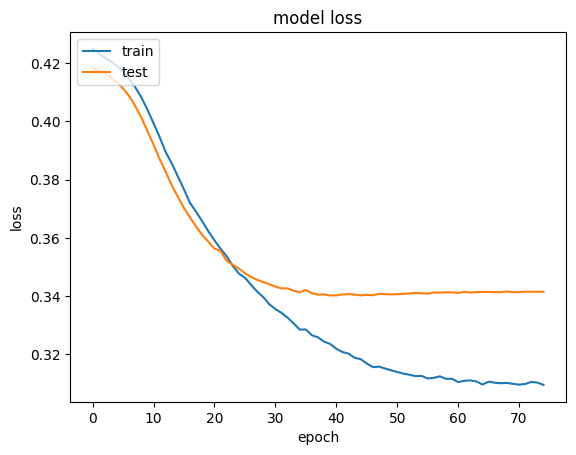

In [232]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Above is the model input shape

In [233]:
user_id = [600]
encoded_user_id = user_enc.transform(user_id)
seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]

**DNN model is used to predict the ratings of the unseen movies.**

In [234]:
predicted_ratings = model.predict(model_input)

print(predicted_ratings.shape)
predicted_ratings

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
(8719, 9)


array([[8.4660614e-01, 1.5320842e-01, 1.0450844e-05, ..., 2.3197446e-05,
        1.8402514e-05, 1.7161048e-05],
       [8.7015182e-01, 1.2967022e-01, 1.0883064e-05, ..., 2.2476097e-05,
        1.7610764e-05, 1.7388355e-05],
       [6.6443676e-01, 3.3526111e-01, 1.3506925e-05, ..., 3.3531203e-05,
        3.0457259e-05, 2.5441583e-05],
       ...,
       [8.2783145e-01, 1.7197871e-01, 1.0368562e-05, ..., 2.2890170e-05,
        1.8843637e-05, 1.7720555e-05],
       [6.4230978e-01, 3.5736302e-01, 1.4319640e-05, ..., 3.4902729e-05,
        3.2811477e-05, 2.7004635e-05],
       [8.6348426e-01, 1.3634217e-01, 1.0205199e-05, ..., 2.1695580e-05,
        1.7231057e-05, 1.6384261e-05]], dtype=float32)

In [235]:
predicted_ratings = np.max(predicted_ratings, axis=1)

print(predicted_ratings.shape)
predicted_ratings

(8719,)


array([0.84660614, 0.8701518 , 0.66443676, ..., 0.82783145, 0.6423098 ,
       0.86348426], dtype=float32)

Index of ratings sorted by descending order.

In [236]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[2962 1513 8403 ... 3225 4726 4758]


**Movie names have been extracted from the available indices we got.**

In [237]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Home Alone 4', 'Confessions', 'Walk on Water', ...,
       'Inherent Vice', "Pan's Labyrinth", "Paris, je t'aime"],
      dtype=object)

### Movies recommended with the help of Softmax Deep Neural Networks

In [238]:
from pprint import pprint

pprint(list(recommended_movies[:20]))

['Home Alone 4',
 'Confessions',
 'Walk on Water',
 'Source Code',
 'Cobra',
 'Jules and Jim',
 'Ernest Goes to Camp',
 'Freaky Friday',
 'Bat*21',
 'City Hall',
 'Police Academy 6: City Under Siege',
 'The Man Who Fell to Earth',
 'Les Girls',
 'Backdraft',
 'Dirty Mary Crazy Larry',
 'Frankie Starlight',
 'Les Amants du Pont-Neuf',
 'Just My Luck',
 'Maximum Conviction',
 'Betty Fisher and Other Stories']


### Summing up the entire code into a recommender system function:

In [239]:
def recommender_system(user_id, model, n_movies):
    print("")
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
    print("")

    encoded_user_id = user_enc.transform([user_id])

    seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
    unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
    model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
    predicted_ratings = model.predict(model_input)
    predicted_ratings = np.max(predicted_ratings, axis=1)
    sorted_index = np.argsort(predicted_ratings)[::-1]
    recommended_movies = item_enc.inverse_transform(sorted_index)
    print("---------------------------------------------------------------------------------")
    print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
    pprint(list(recommended_movies[:n_movies]))

In [240]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
Enter number of movies to be recommended:

Movie seen by the User:
['Air Force One',
 'Aladdin',
 'American Beauty',
 'Apollo 13',
 'Armageddon',
 'Austin Powers: The Spy Who Shagged Me',
 'Back to the Future Part III',
 'Batman & Robin',
 'Blade',
 'Braveheart',
 'Cast Away',
 'Close Encounters of the Third Kind',
 'Crouching Tiger, Hidden Dragon',
 'Dark City',
 'Die Hard 2',
 'Dracula',
 'Forrest Gump',
 'Gladiator',
 'Indiana Jones and the Last Crusade',
 'Jurassic Park',
 'Lethal Weapon 2',
 'Lethal Weapon 4',
 'Mars Attacks!',
 'Minority Report',
 'Mission: Impossible II',
 'Planet of the Apes',
 'Raiders of the Lost Ark',
 'Return of the Jedi',
 'RoboCop',
 'Sleepy Hollow',
 'Star Wars',
 'Star Wars: Episode I - The Phantom Menace',
 'Terminator 2: Judgment Day',
 'That Thing You Do!',
 'The Exorcist',
 'The Fifth Element',
 'The Game',
 'The Green Mile',
 'The Mask of Zorro',
 'The Mummy',
 'The Patriot',
 'The Rock',
 'The Silence of the Lambs',
 'Twelve Monkeys'